# Generative Adversarial Networks: Synthetic Data For Fun and Profit
### Written by: Alex Rusnak

### This notebook contains all the building blocks for a simple GAN, and some examples of how to use it. Though these are toy examples, they illustrate some important concepts about how to use this type of network. 

In [2]:
# Import requirements

import os
import torch
from torch import nn
from torch import optim
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torchvision as tv
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import numpy as np
from PIL import Image
import pandas as pd
import argparse
import cv2
import gc

#Check to make sure GPU is available
!nvidia-smi

Wed Dec  8 16:24:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P3    27W /  N/A |    645MiB / 16125MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Below is the beginning of the code for a very simple deep convolutional GAN, I usually use this as a framework to test components for bigger networks. But because it is so lightweight, it is perfect for this presentation!

In [3]:
# Define the generator class for the network

class Generator(nn.Module):
        def __init__(self, latent_dim=100, batchnorm=True, use_attn=False, size=160, out_chan=3):

            #init 
            super(Generator, self).__init__()
            self.latent_dim = latent_dim
            self.batchnorm = batchnorm
            self.use_attn = use_attn
            self.out_chan = out_chan
            self.layer_size = int(size/2/2)
            self._init_modules()
            
        def _init_modules(self):

            #project input
            self.linear1 = nn.Linear(self.latent_dim, 256*self.layer_size*self.layer_size, bias=False)
            self.bn1d1 = nn.BatchNorm1d(256*self.layer_size*self.layer_size) if self.batchnorm else None
            
            # Using leaky relu as activation layer
            self.leaky_relu = nn.LeakyReLU()

            #regular convolutional layer
            self.conv1 = nn.Conv2d(
                in_channels=256, 
                out_channels=128, 
                kernel_size=5, 
                stride=1,
                padding=2,
                bias=False)
            
            # Defines a batchnorm layer if you flag for it
            self.bn2d1 = nn.BatchNorm2d(128) if self.batchnorm else None
            
            # Defines 2 self attention layers if you flag for it
            if self.use_attn:
                self.attn1 = SelfAttention(128)
                self.attn2 = SelfAttention(128)
                
            # Notice this is a transpose convolution - it is upscaling the data    
            self.conv2 = nn.ConvTranspose2d(
                in_channels=128, 
                out_channels=64, 
                kernel_size=4, 
                stride=2,
                padding=1,
                bias=False)
            
            # Using dropout to prevent overfitting
            self.dropout_2d = nn.Dropout2d(0.1)
            
            # Defines a batchnorm layer if you flag for it
            self.bn2d2 = nn.BatchNorm2d(64) if self.batchnorm else None
            
            #Another transpose convolution
            self.conv3 = nn.ConvTranspose2d(
                in_channels=64, 
                out_channels=self.out_chan, 
                kernel_size=4, 
                stride=2,
                padding=1,
                bias=False)
            
            # Output Activation
            self.tanh = nn.Tanh()
            
        def forward(self, input_tensor):

            # Map latent vectors to samples
            
            intermediate = self.linear1(input_tensor)
            intermediate = self.bn1d1(intermediate)
            intermediate = self.leaky_relu(intermediate)
           
            intermediate = intermediate.view((-1, 256, self.layer_size, self.layer_size))
                
            intermediate = self.conv1(intermediate)
            
            if self.batchnorm:
                intermediate = self.bn2d1(intermediate)
                
            intermediate = self.leaky_relu(intermediate)
            
            intermediate = self.dropout_2d(intermediate)
            
            if self.use_attn:
                intermediate = self.leaky_relu(self.attn1(intermediate))
                intermediate = self.leaky_relu(self.attn2(intermediate))
            
            intermediate = self.conv2(intermediate)
            
            if self.batchnorm:
                intermediate = self.bn2d2(intermediate)
                
            intermediate = self.dropout_2d(intermediate)
            
            intermediate = self.leaky_relu(intermediate)
            
            intermediate = self.conv3(intermediate)
            
            output_tensor = self.tanh(intermediate)
            
            return output_tensor

In [25]:
# Defining the discriminator for the network

class Discriminator(nn.Module):

    def __init__(self, use_attn=False, size=160, in_chan=3, batchnorm=True):
        super(Discriminator, self).__init__()
        
        # init
        self.use_attn = use_attn
        self.layer_size = int(size/2/2)
        self.in_chan = in_chan
        self.batchnorm = batchnorm
        
        self._init_modules()
        
    def _init_modules(self):
        
        # Notice this only uses regular convolutional layers (no upscaling)
        self.conv1 = nn.Conv2d(
            in_channels=self.in_chan,
            out_channels=64,
            kernel_size=5,
            stride=2,
            padding=2,
            bias=True)
        
        self.bn2d1 = nn.BatchNorm2d(64) if self.batchnorm else None
        self.leaky_relu = nn.LeakyReLU()
        
        # Using dropout to prevent overfitting
        self.dropout_2d = nn.Dropout2d(0.3) 

        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=5,
            stride=2,
            padding=2,
            bias=True)
        
        self.bn2d2 = nn.BatchNorm2d(128) if self.batchnorm else None
       
        # Attention if you want it
        if self.use_attn:
            self.attn = SelfAttention(128)
            
        self.linear1 = nn.Linear(128*self.layer_size*self.layer_size, 1, bias=True)
        
        # Sigmoid output activation because this is a binary classifier
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):

        intermediate = self.conv1(input_tensor)
        if self.batchnorm:
            intermediate = self.bn2d1(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)

        intermediate = self.conv2(intermediate)
        if self.batchnorm:
            intermediate = self.bn2d2(intermediate)
        intermediate = self.leaky_relu(intermediate)
        intermediate = self.dropout_2d(intermediate)
        
        if self.use_attn:
                intermediate = self.leaky_relu(self.attn(intermediate))
                
        intermediate = intermediate.view((-1, 128*self.layer_size*self.layer_size))
        
        intermediate = self.linear1(intermediate)
        output_tensor = self.sigmoid(intermediate)

        return output_tensor



In [21]:
# Defining the whole network
class DCGAN():

    def __init__(self, latent_dim, noise_fn, dataloader, 
            batch_size=32, device='cpu', lr_d=1e-3, lr_g=2e-4, use_attn=False, chans=3, size=160, batchnorm_d=True):

        self.generator = Generator(latent_dim, use_attn=use_attn, out_chan=chans, size=size).to(device)
        self.discriminator = Discriminator(use_attn=use_attn, in_chan=chans, size=size, batchnorm=batchnorm_d).to(device)
        
        self.batch_size = batch_size
        self.dataloader = dataloader
        
        self.device = device
        
        self.noise_fn = noise_fn
        self.criterion = nn.BCELoss()

        self.optim_g = optim.Adam(self.generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
        self.optim_d = optim.Adam(self.discriminator.parameters(), lr=lr_d, betas=((0.5, 0.999)))

        self.target_ones = torch.ones((batch_size, 1), device=device)
        self.target_zeros = torch.zeros((batch_size, 1), device=device)
        
    # Saves the generator and discriminator when called
    def saveState(self, epoch=0, chkpt='test'):
        
        print('Saving Checkpoint...')
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.generator.state_dict(),
            'optimizer_state_dict': self.optim_g.state_dict()
            }, "checkpoints/generator/" + chkpt + "G")

        torch.save({
            'epoch': epoch,
            'model_state_dict': self.discriminator.state_dict(),
            'optimizer_state_dict': self.optim_d.state_dict()
            }, "checkpoints/discriminator/" + chkpt + "D")
    
    # Loads the generator and discriminator when called
    def loadState(self, chkpt):

        checkpointG = torch.load("checkpoints/generator/" + chkpt + "G")
        self.generator.load_state_dict(checkpointG['model_state_dict'])
        self.optim_g.load_state_dict(checkpointG['optimizer_state_dict'])

        checkpointD = torch.load("checkpoints/discriminator/" + chkpt + "D")
        self.discriminator.load_state_dict(checkpointD['model_state_dict'])
        self.optim_d.load_state_dict(checkpointD['optimizer_state_dict'])

        #print(self.generator)
        #print(self.discriminator)

        return checkpointD['epoch']
    
    # Generates new samples from the generator when called, can take a latent vector as input
    def generate_samples(self, latent_vec=None, num=None):

        num = self.batch_size if num is None else num
        
        # Generates a latent vector if one is not provided
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec

        with torch.no_grad():
            samples = self.generator(latent_vec)

        samples = samples.cpu()
        latent_vec = latent_vec.cpu()
        # Returns samples (new images) and the latent vector corresponding to those images
        return samples, latent_vec
    
    # Training function for the generator. 
    # Reminder the two networks train in sequence, not concurrently
    def train_step_generator(self):

        self.generator.zero_grad()
        
        latent_vec = self.noise_fn(self.batch_size)
        
        # Generates images
        generated = self.generator(latent_vec)
        
        # Uses the discriminator to classify whether generated images are real or fake
        classifications = self.discriminator(generated)
        
        # Loss function on classifications
        loss = self.criterion(classifications, self.target_ones)

        loss.backward()
        self.optim_g.step()
        return loss.item()
    
    # Training function for the discriminator
    def train_step_discriminator(self, real_samples):
        
        self.discriminator.zero_grad()
        
        # Discriminates on only REAL images and then finds loss for those predictions
        pred_real = self.discriminator(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)
        
        latent_vec = self.noise_fn(self.batch_size)

        with torch.no_grad():
            # uses the generator to create new FAKE images
            fake_samples = self.generator(latent_vec)
            
        # Discriminates on only FAKE images and then finds loss for those predictions
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)
        
        # Loss is average of two losses 
        loss = (loss_real + loss_fake) / 2

        loss.backward()

        self.optim_d.step()

        return loss_real.item(), loss_fake.item()
    
    # Trains one epoch (self explanatory)
    def train_epoch(self, print_frequency=10, max_steps=0):

        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0

        for batch, (real_samples, _) in enumerate(self.dataloader):
            
            real_samples = real_samples.to(self.device)
            
            # Train D step for batch
            if (len(real_samples) == 32):
                ldr_, ldf_ = self.train_step_discriminator(real_samples)

            loss_d_real_running  += ldr_
            loss_d_fake_running  += ldf_
            
            # Train G step for batch
            loss_g_running += self.train_step_generator()
            
            # Prints losses
            if print_frequency and (batch+1) % print_frequency ==0:
                    
                    print(f"{batch+1}/{len(self.dataloader)}:"
                      f" G={loss_g_running / (batch+1):.3f},"
                      f" Dr={loss_d_real_running / (batch+1):.3f},"
                      f" Df={loss_d_fake_running / (batch+1):.3f}",
                      end='\r',
                      flush=True)
                 

            if max_steps and batch == max_steps:
                break

        if print_frequency:
            print()
        
        loss_g_running /= batch
        loss_d_real_running /= batch
        loss_d_fake_running /= batch
        
        # Returns avg losses for epoch
        return [loss_g_running, loss_d_real_running, loss_d_fake_running]



In [6]:
# Attention Layer - beyond the scope of this presentation, but useful!
def init_conv(conv, glu=True):
    init.xavier_uniform_(conv.weight)
    if conv.bias is not None:
        conv.bias.data.zero_()

class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation=F.relu):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #

        init_conv(self.query_conv)
        init_conv(self.key_conv)
        init_conv(self.value_conv)
        
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out

In [23]:
# Main function for running the GAN
# Accepts a run type (load, train, or gen), a checkpoint name for the networks, epochs, 
# whether to use attention, a latent vector for gen mode only, and a modification to the 
# name of saved images to differentiate between gen runs

def runGAN(gen_or_train='train', chkpt_name='test', dataset='test', epochs=500, 
           use_attn=False, size=160, latent_vec='', gen_name_mod='', folder_mod='Random/', 
           bw=False):
        
        # Define important variables
        batch_size = 32
        epochs = int(epochs)
        latent_dim = 16
        
        # Create a loss tape for plotting
        loss_tape = [[0]*3]*epochs
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #print(device)
        
        # Transforms on images
        if bw:
            channels = 1
            batchnorm_d = True
            transform = tv.transforms.Compose([
                tv.transforms.Grayscale(num_output_channels=1),
                tv.transforms.ToTensor(),
                #tv.transforms.Normalize((0.5,), (0.5,))
                ])
        else:
            channels = 3
            batchnorm_d = False
            transform = tv.transforms.Compose([
                #tv.transforms.Grayscale(num_output_channels=1),
                tv.transforms.ToTensor(),
                #tv.transforms.Normalize((0.5,), (0.5,))
                ])

        # Creates dataset
        dataset = ImageFolder(
            root=dataset,
            transform = transform)
        checkpointFrequency = 10
        # Creates dataloader from dataset
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
        
        # Define noise fucntion
        noise_fn = lambda x: torch.randn((x, latent_dim), device=device)
        
        # Creates the GAN with specifications
        gan = DCGAN(latent_dim, noise_fn, dataloader, device=device, batch_size=batch_size,
                    use_attn=use_attn, chans=channels, size=size, batchnorm_d=batchnorm_d)
        
        # Loads GAN state and restarts training
        if(gen_or_train == 'load'):
            
            start = time()
            epoch = gan.loadState(chkpt_name) + 1
            
            for i in range(epoch, epochs):
                print(f"Epoch {i+1}; Elapsed Time = {int(time()- start)}s ")
                gan.train_epoch()
                if(i%checkpointFrequency==0):
                    gan.saveState(i+1, chkpt_name)

            images, latent_vec = gan.generate_samples() 
            images = images * -1
        
        # Trains fresh GAN 
        elif(gen_or_train == 'train'):
            
            start = time()

            for i in range(epochs): 
                print(f"Epoch {i+1}; Elapsed Time = {int(time()- start)}s ")
                loss_tape[i] = gan.train_epoch()
               
                if(i%checkpointFrequency==0):
                    gan.saveState(i, chkpt_name)
                
            images, latent_vec = gan.generate_samples() 
            images = images * -1
        
        # Generates new samples
        elif(gen_or_train == 'gen'):
            
            # Loads checkpoint
            epoch = gan.loadState(chkpt_name)
            
            # Generates samples from given latent vec
            if len(latent_vec)!=0:
                latent_vec = latent_vec.to(device)
                images, latent_vec = gan.generate_samples(latent_vec)
                
            # Generates samples from new / random latent vec
            else:
                images, latent_vec = gan.generate_samples()
    
            images = images * -1
            
             # Saves generated images
            for i in range(len(images)):
                
                img = transforms.ToPILImage()(images[i])
                img.save('data/GeneratedImages/' + folder_mod + gen_name_mod + '_'+ str(i) + '.png') 

        # Plots images
        ims = tv.utils.make_grid(images, normalize=True)

        plt.imshow(ims.numpy().transpose((1,2,0)))
        plt.show()
        
        del gan
        gc.collect()
        
        # returns loss_tape for plotting and last latent vector used to generate images
        return loss_tape, latent_vec

## Time to train! 
![alt text](data/PresentationImages/gan_training.png "Rivals")

Epoch 1; Elapsed Time = 0s 
20/23: G=37.920, Dr=0.643, Df=0.665
Saving Checkpoint...
Epoch 2; Elapsed Time = 4s 
20/23: G=10.198, Dr=0.154, Df=0.270
Epoch 3; Elapsed Time = 8s 
20/23: G=4.756, Dr=0.224, Df=0.275
Epoch 4; Elapsed Time = 13s 
20/23: G=2.271, Dr=0.392, Df=0.496
Epoch 5; Elapsed Time = 17s 
20/23: G=2.290, Dr=0.511, Df=0.441
Epoch 6; Elapsed Time = 21s 
20/23: G=2.089, Dr=0.306, Df=0.333
Epoch 7; Elapsed Time = 26s 
20/23: G=2.078, Dr=0.355, Df=0.390
Epoch 8; Elapsed Time = 30s 
20/23: G=2.210, Dr=0.604, Df=0.425
Epoch 9; Elapsed Time = 34s 
20/23: G=2.784, Dr=0.310, Df=0.311
Epoch 10; Elapsed Time = 39s 
20/23: G=2.183, Dr=0.481, Df=0.426
Epoch 11; Elapsed Time = 43s 
20/23: G=1.893, Dr=0.408, Df=0.428
Saving Checkpoint...
Epoch 12; Elapsed Time = 47s 
20/23: G=2.195, Dr=0.393, Df=0.313
Epoch 13; Elapsed Time = 52s 
20/23: G=2.473, Dr=0.343, Df=0.314
Epoch 14; Elapsed Time = 56s 
20/23: G=2.213, Dr=0.411, Df=0.378
Epoch 15; Elapsed Time = 61s 
20/23: G=2.156, Dr=0.409, Df

20/23: G=4.637, Dr=0.081, Df=0.073
Epoch 240; Elapsed Time = 1051s 
20/23: G=4.115, Dr=0.202, Df=0.197
Epoch 241; Elapsed Time = 1056s 
20/23: G=4.565, Dr=0.123, Df=0.092
Saving Checkpoint...
Epoch 242; Elapsed Time = 1060s 
20/23: G=4.825, Dr=0.153, Df=0.125
Epoch 243; Elapsed Time = 1065s 
20/23: G=4.318, Dr=0.115, Df=0.120
Epoch 244; Elapsed Time = 1069s 
20/23: G=4.359, Dr=0.119, Df=0.085
Epoch 245; Elapsed Time = 1073s 
20/23: G=4.336, Dr=0.125, Df=0.106
Epoch 246; Elapsed Time = 1077s 
20/23: G=4.143, Dr=0.131, Df=0.095
Epoch 247; Elapsed Time = 1082s 
20/23: G=4.278, Dr=0.098, Df=0.101
Epoch 248; Elapsed Time = 1086s 
20/23: G=4.475, Dr=0.141, Df=0.104
Epoch 249; Elapsed Time = 1090s 
20/23: G=4.039, Dr=0.131, Df=0.105
Epoch 250; Elapsed Time = 1095s 
20/23: G=3.923, Dr=0.344, Df=0.253
Epoch 251; Elapsed Time = 1099s 
20/23: G=4.269, Dr=0.154, Df=0.135
Saving Checkpoint...
Epoch 252; Elapsed Time = 1103s 
20/23: G=4.203, Dr=0.091, Df=0.094
Epoch 253; Elapsed Time = 1108s 
20/23:

20/23: G=4.676, Dr=0.221, Df=0.127
Epoch 357; Elapsed Time = 1533s 
20/23: G=4.804, Dr=0.091, Df=0.099
Epoch 358; Elapsed Time = 1537s 
20/23: G=4.769, Dr=0.093, Df=0.081
Epoch 359; Elapsed Time = 1542s 
20/23: G=4.790, Dr=0.078, Df=0.237
Epoch 360; Elapsed Time = 1546s 
20/23: G=4.890, Dr=0.057, Df=0.056
Epoch 361; Elapsed Time = 1550s 
20/23: G=5.146, Dr=0.081, Df=0.079
Saving Checkpoint...
Epoch 362; Elapsed Time = 1555s 
20/23: G=5.257, Dr=0.096, Df=0.070
Epoch 363; Elapsed Time = 1559s 
20/23: G=4.825, Dr=0.199, Df=0.219
Epoch 364; Elapsed Time = 1563s 
20/23: G=4.466, Dr=0.251, Df=0.377
Epoch 365; Elapsed Time = 1568s 
20/23: G=4.456, Dr=0.073, Df=0.087
Epoch 366; Elapsed Time = 1572s 
20/23: G=4.560, Dr=0.107, Df=0.090
Epoch 367; Elapsed Time = 1576s 
20/23: G=4.963, Dr=0.054, Df=0.221
Epoch 368; Elapsed Time = 1581s 
20/23: G=4.814, Dr=0.072, Df=0.063
Epoch 369; Elapsed Time = 1585s 
20/23: G=4.877, Dr=0.082, Df=0.079
Epoch 370; Elapsed Time = 1589s 
20/23: G=4.883, Dr=0.090, D

20/23: G=5.548, Dr=0.060, Df=0.037
Epoch 474; Elapsed Time = 2042s 
20/23: G=5.920, Dr=0.088, Df=0.056
Epoch 475; Elapsed Time = 2046s 
20/23: G=5.362, Dr=0.066, Df=0.066
Epoch 476; Elapsed Time = 2050s 
20/23: G=5.340, Dr=0.046, Df=0.038
Epoch 477; Elapsed Time = 2055s 
20/23: G=5.360, Dr=0.056, Df=0.031
Epoch 478; Elapsed Time = 2059s 
20/23: G=5.846, Dr=0.292, Df=0.296
Epoch 479; Elapsed Time = 2063s 
20/23: G=5.088, Dr=0.061, Df=0.078
Epoch 480; Elapsed Time = 2068s 
20/23: G=5.909, Dr=0.050, Df=0.196
Epoch 481; Elapsed Time = 2072s 
20/23: G=5.461, Dr=0.041, Df=0.057
Saving Checkpoint...
Epoch 482; Elapsed Time = 2077s 
20/23: G=5.859, Dr=0.068, Df=0.052
Epoch 483; Elapsed Time = 2081s 
20/23: G=5.947, Dr=0.146, Df=1.029
Epoch 484; Elapsed Time = 2085s 
20/23: G=5.495, Dr=0.100, Df=0.105
Epoch 485; Elapsed Time = 2090s 
20/23: G=5.282, Dr=0.048, Df=0.052
Epoch 486; Elapsed Time = 2094s 
20/23: G=5.368, Dr=0.065, Df=0.058
Epoch 487; Elapsed Time = 2098s 
20/23: G=5.507, Dr=0.047, D

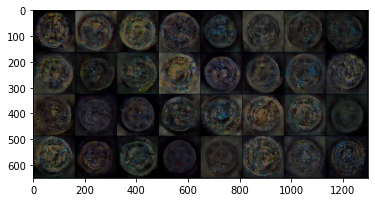

In [52]:
#lt, lv = runGAN(chkpt_name='PorcelainDemo', dataset='data/RealImageData/', epochs=500, use_attn=True, bw=False, size=160)

Epoch 1; Elapsed Time = 0s 
20/23: G=18.129, Dr=1.679, Df=1.622
Saving Checkpoint...
Epoch 2; Elapsed Time = 4s 
20/23: G=6.638, Dr=0.204, Df=0.267
Epoch 3; Elapsed Time = 8s 
20/23: G=8.860, Dr=0.146, Df=0.270
Epoch 4; Elapsed Time = 12s 
20/23: G=5.777, Dr=0.188, Df=0.420
Epoch 5; Elapsed Time = 16s 
20/23: G=2.987, Dr=0.260, Df=0.389
Epoch 6; Elapsed Time = 21s 
20/23: G=2.124, Dr=0.302, Df=0.364
Epoch 7; Elapsed Time = 25s 
20/23: G=2.199, Dr=0.322, Df=0.316
Epoch 8; Elapsed Time = 29s 
20/23: G=2.156, Dr=0.397, Df=0.421
Epoch 9; Elapsed Time = 33s 
20/23: G=2.239, Dr=0.611, Df=0.497
Epoch 10; Elapsed Time = 38s 
20/23: G=2.774, Dr=0.203, Df=0.218
Epoch 11; Elapsed Time = 42s 
20/23: G=3.345, Dr=0.419, Df=0.336
Saving Checkpoint...
Epoch 12; Elapsed Time = 46s 
20/23: G=2.743, Dr=0.284, Df=0.258
Epoch 13; Elapsed Time = 50s 
20/23: G=2.667, Dr=0.378, Df=0.441
Epoch 14; Elapsed Time = 55s 
20/23: G=2.163, Dr=0.464, Df=0.413
Epoch 15; Elapsed Time = 59s 
20/23: G=2.023, Dr=0.390, Df=

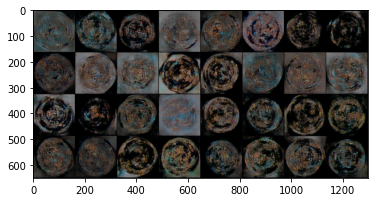

In [26]:
lt, lv = runGAN(chkpt_name='PorcelainYourRun', dataset='data/RealImageData/', epochs=100, use_attn=True, bw=False, size=160)

<AxesSubplot:xlabel='index', ylabel='value'>

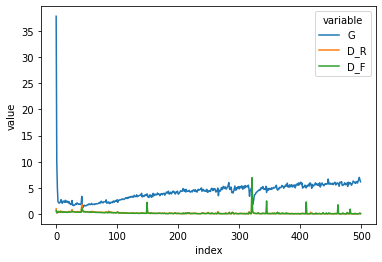

In [54]:
# Plots the loss values for the generator, and the discrimininator on real and fake images.
lt_df = pd.melt(pd.DataFrame(lt).rename({0:'G',1:'D_R', 2:'D_F'}, axis=1), ignore_index=False).reset_index()
sns.lineplot(data=lt_df, x='index', y='value', hue='variable')

![alt text](data/PresentationImages/LongTrainingLoss.png "LTL")

![alt text](data/PresentationImages/Ash_and_Gary.png "Rivals")

### The generator and discriminator are battling each other, and in the process making each other better! However, this makes the loss values a bit confusing, as they don't seem to converge as a normal network would. They seem to hover in equilibrium or go in the wrong direction sometimes, even though the quality of images is improving. 

### This is common for GANs, and why our evaluation criteria of data quality is often subjective. There is much debate over the best way to measure objectively and precisely the quality / realness of the output. Since it is so hard to define what is 'realistic' data, that is why GANs are actually important because you don't have to explicitly define what is 'realness.' 

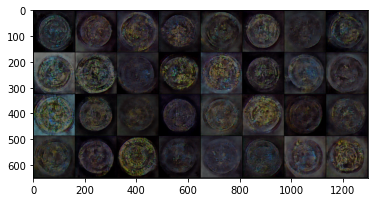

In [55]:
# Generate some new images!
lt, lv = runGAN(chkpt_name='PorcelainDemo', dataset='data/RealImageData/', use_attn=True, gen_or_train='gen', gen_name_mod='porcelain_', folder_mod='Porcelain/')

### These are cool! Unfortunately this network and dataset are kind of small - here is what you could make using a larger version of this same network / dataset: 

![alt text](data/PresentationImages/109.png "Plate 1")
![alt text](data/PresentationImages/119.png "Plate 2")

### Using different architectures and better datasets can give you even higher quality images! 

![alt text](data/PresentationImages/styleGan.jpg "StyleGAN")


![alt text](data/PresentationImages/gan_output.jpeg "Plate 2")

## Well that was fun! But I was promised profit also! Where is my profit?

## Solution: Sell your plate images as NFTs on the internet! Instant profit! 

![alt text](data/PresentationImages/YourNFT.png "NFT")

## Ok, now I have a ton of cryptocurrency! What now? 

## Solution: Become a degenerate cryptocurrency day trader who uses machine learning!

![alt text](data/PresentationImages/stonks.jpg "stonks")

## BTC Price data:

In [39]:
btc = pd.read_parquet('data/FinancialData/BTC-USD.pq')
btc

,datetime,close
0,2013-04-01 00:07:00,93.3000
1,2013-04-01 00:08:00,100.0000
2,2013-04-01 00:09:00,93.3000
3,2013-04-01 00:11:00,93.4700
4,2013-04-01 00:12:00,93.4700
...,...,...
3147684,2021-01-01 15:05:00,29352.0000
3147685,2021-01-01 15:06:00,29363.6385
3147686,2021-01-01 15:07:00,29357.0000
3147687,2021-01-01 15:08:00,29367.0000


In [190]:
# Here we are turning the financial time series into an image. In the real world this is 
# unnecessary / frowned upon. Use your data in its natural format, and an architecture that
# is suitable. But for this demo, it allows us to use roughly the same architecture from before.

def seriesToImage(image, finalValue, counter, size):
    image = (image - image.min()) / (image.max() - image.min()) #to normalize
    image = image * 256
    
    #image = np.expand_dims(image, 2)
    image = Image.fromarray(np.uint8(image) , 'L')
    #sv = np.zeros([size, size, 2])
    #sv[:, :, 0] = 1000 
    #sv[:, :, 1] = 200 

    #hsv_image = np.concatenate([image, sv], 2).astype(np.uint8)
    #rgb_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    #im = Image.fromarray(rgb_image)
    
    # Seperate images where the final value of the series is lower than 
    # the first from those where it is higher. i.e. a loss or a gain
    
    if finalValue < 0:
        image.save('data/FinancialImages/BW/Neg/' + str(counter) + '_' + "{:.5f}".format(finalValue)+ '.png', "PNG")
    if finalValue >= 0:
        image.save('data/FinancialImages/BW/Pos/' + str(counter) + '_' + "{:.5f}".format(finalValue)+ '.png', "PNG")

In [191]:
size = 32

for j in range(3073):
    if j % 500 == 0:
        print(j)
    counter = 0
    imageMatrix = np.zeros((size, size))
    startVal = j * (size*size)
    for i in range(startVal, startVal + (size*size), size):
        temp = btc[i:i+size]['close'].reset_index(drop=True)
        
        if counter == 0:
            
            start = temp[0]

        imageMatrix[counter, :] = ((start/temp)-1).to_numpy()
        counter +=1
        
    seriesToImage(imageMatrix, imageMatrix[size-1,size-1], j, size)

0
500
1000
1500
2000
2500
3000


### Positive Series (White == Higher)
![alt text](data/PresentationImages/FinPosBW.png "Pos")
### Negative Series (Black == Lower)
![alt text](data/PresentationImages/NegFinBW.png "Neg")

## Ok! Let's train some more models!

In [23]:
# Defining a small binary classifier to use in our future tests
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 2 convolutional layers, one linear
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=5,
            stride=2,
            padding=2,
            bias=True)

        self.leaky_relu = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=5,
            stride=2,
            padding=2,
            bias=True)
        
        # 2 fully connected layers
        self.fc1 = nn.Linear(128*4*4, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    # Forward pass of network
    def forward(self, x):
        # convolutional layer 1 with relu activation
        x = F.relu(self.conv1(x))
        # convolutional layer 2, followed by a 2d pooling layer, with relu activation
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Dropout layer 1
        x = F.dropout(x, p=0.5, training=self.training)
        # Reshape the tensor for the fully connected layers
        x = x.view(-1,128*4*4)
        # Fully connected layer 1 with relu
        x = F.relu(self.fc1(x))
        
        return self.sigmoid(x)

# Fit the model to data
def fit(model, trainLoader, epochs):
    # Define optimizer as Adam
    optimizer = torch.optim.Adam(model.parameters())
    # Define loss function and cross entropy
    loss_func = nn.BCELoss()
    # Start Training
    model.train()
    # Train for the correct number of epochs
    loss_tape = [0]*epochs
    for epoch in range(epochs):
        # This variable tracks how many correct predictions were made in each epoch
        correct = 0
        # Seperate loader into a batch at each step
        for batch_idx, (X_batch, y_batch) in enumerate(trainLoader):
            
            # Convert batch representations to variable floats for input
            X_V = Variable(X_batch).float()
            y_V = Variable(y_batch)
    
            # Zero out the gradients 
            optimizer.zero_grad()
            # Get a prediction from the model
            out = model(X_V)
        
            # Get the loss of the predicted and actual class
            loss = loss_func(out, y_V)
            # Backpropagate the loss
            loss.backward()
            # optimize the gradients using Adam
            optimizer.step()
            
            # Get the prediction and determine if it is correct
            pred = torch.round(out)
            correct += (pred == y_V).sum()
            
            # Print the loss and accuracy at the end of each epoch
            if batch_idx % 999 == 0:
                loss_tape[epoch] = loss.cpu().detach()
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(trainLoader.dataset), 100.*batch_idx / len(trainLoader), loss.data.item(), float(correct*100) / float(batchSize*(batch_idx+1))))         
    return loss_tape
# Evaluates data on test data
def evalModel(model, testLoader, full):
    # Counts correct predictions
    correct = 0 
    loss = 0
    loss_func = nn.BCELoss()
    for test_X, test_y in testLoader:
        # Turns batch to variable
        test_X = Variable(test_X).float()
        y_V = Variable(test_y)
        # Gets label prediction
        out = model(test_X)
        pred = torch.round(out)
        
        loss += loss_func(out, y_V)
        # Track corrects
        correct += (pred == test_y).sum()
    # Print accuracy
    print("Test accuracy:  {:.3f}% Avg loss:  {:.3f}".format( (float(correct) / (len(testLoader)*batchSize))*100, (float(loss) / (len(testLoader)))))

# Turns images into tensors, and erases the second half of the data so we can predict it. 
def turnToTensors(fileList, folder, cut=True):
    for i, fileName in enumerate(fileList):
        im = Image.open(folder + fileName)
        if i == 0: 
            imT = transforms.ToTensor()(im)
            if cut:
                imT[:, 16:, :] = 0
            stack = imT[None, :]
        else:
            imT = transforms.ToTensor()(im)
            if cut:
                imT[:, 16:, :] = 0
            stack = torch.cat((stack, imT[None, :]))
    return stack

In [31]:
# Loading the BTC time series images we made earlier and seperating them into train / test sets with 
# different class balances

dataDir = 'data/FinancialImages/BW/'
listNeg = os.listdir(dataDir +'Neg/')
stackNeg = turnToTensors(listNeg, dataDir +'Neg/')

listPos = os.listdir(dataDir +'Pos/')
stackPos = turnToTensors(listPos, dataDir +'Pos/')

target_ones = torch.ones((len(stackPos), 1))
target_zeros = torch.zeros((len(stackNeg), 1))

# Notice we seperate samples from the past and test on ones from the 'future' 
# from the perspective of the model.

setPos_Train = torch.cat((stackPos[:1100], stackNeg[1000:1100]))
setBal_Train = torch.cat((stackPos[:1100], stackNeg[:1100]))

setNeg_Test = torch.cat((stackPos[1100:1200], stackNeg[1100:1400]))
setBal_Test = torch.cat((stackPos[1100:1400], stackNeg[1100:1400]))

targetsPos_Train = torch.cat((target_ones[:1100], target_zeros[1000:1100]))
targetsBal_Train = torch.cat((target_ones[:1100], target_zeros[:1100]))

targetsNeg_Test = torch.cat((target_ones[1100:1200], target_zeros[1100:1400]))
targetsBal_Test = torch.cat((target_ones[1100:1400], target_zeros[1100:1400]))

dataPos_Train = torch.utils.data.TensorDataset(setPos_Train,targetsPos_Train)
dataBal_Train = torch.utils.data.TensorDataset(setBal_Train,targetsBal_Train)

dataNeg_Test = torch.utils.data.TensorDataset(setNeg_Test,targetsNeg_Test)
dataBal_Test = torch.utils.data.TensorDataset(setBal_Test,targetsBal_Test)

batchSize = 8

trainLoaderPos = torch.utils.data.DataLoader(dataPos_Train, batch_size = batchSize, shuffle = True)
trainLoaderBal = torch.utils.data.DataLoader(dataBal_Train, batch_size = batchSize, shuffle = True)

testLoaderNeg = torch.utils.data.DataLoader(dataNeg_Test, batch_size = batchSize, shuffle = True)
testLoaderBal = torch.utils.data.DataLoader(dataBal_Test, batch_size = batchSize, shuffle = True)

print('Loaded data!')

Loaded data!


In [194]:
# We only have 2200 total samples to train with! this is really not enough for machine learning. 
print(len(setBal_Train))

2200


## So the idea here is to train this CNN to take the first half of the data (a couple of hours) and then predict if the price will be higher or lower than the starting price by the end of the sample. 

In [286]:
classifierCNN = CNN()

print("Training the model on balanced data:")
print('           -------------------------------------')
print('           -------------------------------------')
print('Architecture of the model:')
print(str(classifierCNN))
print('           -------------------------------------')
lt = fit(classifierCNN, trainLoaderBal, 20)
print('           -------------------------------------')
print('')
print('')


print("Evaluation of model on balanced data:")
print('           -------------------------------------')
evalModel(classifierCNN, testLoaderBal, False)
print('           -------------------------------------')
print('')
print('')

print("Evaluation of model on unbalanced data:")
print('           -------------------------------------')
evalModel(classifierCNN, testLoaderNeg, False)
print('           -------------------------------------')


Training the model on balanced data:
           -------------------------------------
           -------------------------------------
Architecture of the model:
CNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (fc1): Linear(in_features=2048, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
           -------------------------------------
Epoch : 0 [0/2200 (0%)]	Loss: 0.693147	 Accuracy:37.500%
Epoch : 1 [0/2200 (0%)]	Loss: 0.305064	 Accuracy:87.500%
Epoch : 2 [0/2200 (0%)]	Loss: 0.521590	 Accuracy:87.500%
Epoch : 3 [0/2200 (0%)]	Loss: 0.627431	 Accuracy:50.000%
Epoch : 4 [0/2200 (0%)]	Loss: 0.544845	 Accuracy:100.000%
Epoch : 5 [0/2200 (0%)]	Loss: 0.568361	 Accuracy:75.000%
Epoch : 6 [0/2200 (0%)]	Loss: 0.474942	 Accuracy:87.500%
Epoch : 7 [0/2200 (0%)]	Loss: 0.610969	 Accuracy:100.000%
Epoch : 8 [0/2200 (0%)]	Loss: 0.454683	

### Amazing! We will be billionaires in no time! 


### Not so fast! There are paradigm shifts in finance all the time, lets see what would happen in that scenario. Furthermore, not all coins have the same equal distribution of gain and loss over time. A key usecase for GANs is for fixing unbalanced data or training data that is not the same distribution of classes as it will be in the future / in production.

## Here we will train the model on data where most of the samples are increasing, and then test on a balanced set of samples and on one where most samples are decreasing. 

<AxesSubplot:ylabel='Count'>

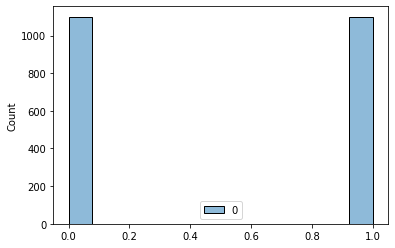

In [235]:
# Balanced dataset class distribution is even
sns.histplot(data=pd.DataFrame(np.array(targetsBal_Train)))

<AxesSubplot:ylabel='Count'>

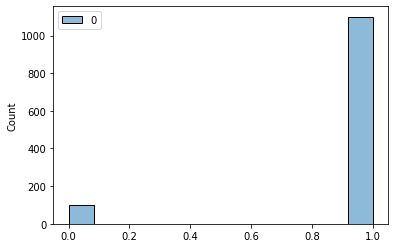

In [236]:
# Positive training dataset distribution is unbalanced
sns.histplot(data=pd.DataFrame(np.array(targetsPos_Train)))

<AxesSubplot:ylabel='Count'>

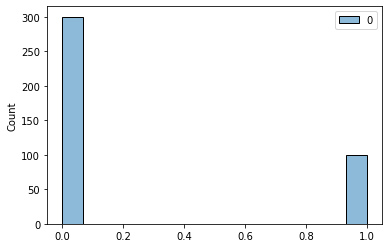

In [237]:
# Negative test dataset distribution is unbalanced
sns.histplot(data=pd.DataFrame(np.array(targetsNeg_Test)))

In [242]:
classifierCNN = CNN()

print("Training the model on unbalanced data:")
print('           -------------------------------------')
print('           -------------------------------------')
fit(classifierCNN, trainLoaderPos, 20)
print('           -------------------------------------')
print('')
print('')


print("Evaluation of model on balanced data:")
print('           -------------------------------------')
evalModel(classifierCNN, testLoaderBal, False)
print('           -------------------------------------')
print('')
print('')

print("Evaluation of model on unbalanced data:")
print('           -------------------------------------')
evalModel(classifierCNN, testLoaderNeg, False)
print('           -------------------------------------')

Training the model on unbalanced data:
           -------------------------------------
           -------------------------------------
Epoch : 0 [0/1200 (0%)]	Loss: 0.691001	 Accuracy:37.500%
Epoch : 1 [0/1200 (0%)]	Loss: 0.110314	 Accuracy:100.000%
Epoch : 2 [0/1200 (0%)]	Loss: 0.172787	 Accuracy:100.000%
Epoch : 3 [0/1200 (0%)]	Loss: 0.661257	 Accuracy:87.500%
Epoch : 4 [0/1200 (0%)]	Loss: 0.067670	 Accuracy:100.000%
Epoch : 5 [0/1200 (0%)]	Loss: 0.029519	 Accuracy:100.000%
Epoch : 6 [0/1200 (0%)]	Loss: 0.141680	 Accuracy:100.000%
Epoch : 7 [0/1200 (0%)]	Loss: 0.098680	 Accuracy:100.000%
Epoch : 8 [0/1200 (0%)]	Loss: 0.318027	 Accuracy:87.500%
Epoch : 9 [0/1200 (0%)]	Loss: 0.012529	 Accuracy:100.000%
Epoch : 10 [0/1200 (0%)]	Loss: 0.004109	 Accuracy:100.000%
Epoch : 11 [0/1200 (0%)]	Loss: 0.018174	 Accuracy:100.000%
Epoch : 12 [0/1200 (0%)]	Loss: 0.175652	 Accuracy:100.000%
Epoch : 13 [0/1200 (0%)]	Loss: 0.001646	 Accuracy:100.000%
Epoch : 14 [0/1200 (0%)]	Loss: 0.036104	 Accuracy:

## Ok we are seeing a substantial degradation of predictions. So even when the prediction is correct, the model is less sure, which matters a lot because we only want to take sure bets. 

## Ok let's try to fix this class imbalance using our GAN!

Epoch 1; Elapsed Time = 0s 
90/97: G=8.057, Dr=0.015, Df=0.018
Saving Checkpoint...
Epoch 2; Elapsed Time = 2s 
90/97: G=11.155, Dr=0.061, Df=0.135
Epoch 3; Elapsed Time = 4s 
90/97: G=5.500, Dr=0.168, Df=0.126
Epoch 4; Elapsed Time = 7s 
90/97: G=5.544, Dr=0.150, Df=0.107
Epoch 5; Elapsed Time = 9s 
90/97: G=5.945, Dr=0.078, Df=0.059
Epoch 6; Elapsed Time = 11s 
90/97: G=6.320, Dr=0.148, Df=0.115
Epoch 7; Elapsed Time = 13s 
90/97: G=6.150, Dr=0.265, Df=0.216
Epoch 8; Elapsed Time = 16s 
90/97: G=4.561, Dr=0.297, Df=0.257
Epoch 9; Elapsed Time = 18s 
90/97: G=4.008, Dr=0.336, Df=0.290
Epoch 10; Elapsed Time = 20s 
90/97: G=3.998, Dr=0.289, Df=0.272
Epoch 11; Elapsed Time = 23s 
90/97: G=3.888, Dr=0.244, Df=0.243
Saving Checkpoint...
Epoch 12; Elapsed Time = 25s 
90/97: G=3.666, Dr=0.342, Df=0.332
Epoch 13; Elapsed Time = 28s 
90/97: G=3.668, Dr=0.268, Df=0.251
Epoch 14; Elapsed Time = 30s 
90/97: G=3.602, Dr=0.308, Df=0.284
Epoch 15; Elapsed Time = 32s 
90/97: G=3.421, Dr=0.281, Df=0.

90/97: G=8.541, Dr=0.063, Df=0.066
Epoch 240; Elapsed Time = 569s 
90/97: G=8.905, Dr=0.048, Df=0.044
Epoch 241; Elapsed Time = 571s 
90/97: G=8.978, Dr=0.067, Df=0.055
Saving Checkpoint...
Epoch 242; Elapsed Time = 574s 
90/97: G=8.914, Dr=0.055, Df=0.058
Epoch 243; Elapsed Time = 576s 
90/97: G=8.759, Dr=0.062, Df=0.060
Epoch 244; Elapsed Time = 578s 
90/97: G=8.989, Dr=0.051, Df=0.047
Epoch 245; Elapsed Time = 580s 
90/97: G=8.827, Dr=0.051, Df=0.047
Epoch 246; Elapsed Time = 583s 
90/97: G=9.032, Dr=0.068, Df=0.0587
Epoch 247; Elapsed Time = 585s 
90/97: G=8.645, Dr=0.056, Df=0.046
Epoch 248; Elapsed Time = 587s 
90/97: G=8.979, Dr=0.071, Df=0.063
Epoch 249; Elapsed Time = 590s 
90/97: G=8.622, Dr=0.061, Df=0.056
Epoch 250; Elapsed Time = 592s 
90/97: G=8.692, Dr=0.057, Df=0.055
Epoch 251; Elapsed Time = 595s 
90/97: G=8.717, Dr=0.067, Df=0.058
Saving Checkpoint...
Epoch 252; Elapsed Time = 597s 
90/97: G=8.439, Dr=0.058, Df=0.047
Epoch 253; Elapsed Time = 599s 
90/97: G=8.501, Dr=

90/97: G=9.616, Dr=0.033, Df=0.026
Epoch 358; Elapsed Time = 848s 
90/97: G=10.083, Dr=0.032, Df=0.028
Epoch 359; Elapsed Time = 850s 
90/97: G=9.697, Dr=0.045, Df=0.0432
Epoch 360; Elapsed Time = 853s 
90/97: G=9.786, Dr=0.041, Df=0.027
Epoch 361; Elapsed Time = 855s 
90/97: G=9.644, Dr=0.030, Df=0.029
Saving Checkpoint...
Epoch 362; Elapsed Time = 857s 
90/97: G=9.969, Dr=0.038, Df=0.0365
Epoch 363; Elapsed Time = 859s 
90/97: G=10.123, Dr=0.033, Df=0.027
Epoch 364; Elapsed Time = 862s 
90/97: G=10.286, Dr=0.040, Df=0.037
Epoch 365; Elapsed Time = 864s 
90/97: G=9.872, Dr=0.044, Df=0.0360
Epoch 366; Elapsed Time = 867s 
90/97: G=9.901, Dr=0.034, Df=0.034
Epoch 367; Elapsed Time = 869s 
90/97: G=10.151, Dr=0.036, Df=0.033
Epoch 368; Elapsed Time = 871s 
90/97: G=10.378, Dr=0.025, Df=0.023
Epoch 369; Elapsed Time = 874s 
90/97: G=10.610, Dr=0.030, Df=0.021
Epoch 370; Elapsed Time = 876s 
90/97: G=10.576, Dr=0.028, Df=0.024
Epoch 371; Elapsed Time = 878s 
90/97: G=10.646, Dr=0.028, Df=0

90/97: G=12.299, Dr=0.016, Df=0.012
Epoch 589; Elapsed Time = 1393s 
90/97: G=11.642, Dr=0.023, Df=0.019
Epoch 590; Elapsed Time = 1396s 
90/97: G=11.730, Dr=0.019, Df=0.017
Epoch 591; Elapsed Time = 1398s 
90/97: G=11.994, Dr=0.026, Df=0.019
Saving Checkpoint...
Epoch 592; Elapsed Time = 1400s 
90/97: G=11.205, Dr=0.031, Df=0.026
Epoch 593; Elapsed Time = 1403s 
90/97: G=11.402, Dr=0.040, Df=0.033
Epoch 594; Elapsed Time = 1405s 
90/97: G=10.771, Dr=0.042, Df=0.032
Epoch 595; Elapsed Time = 1408s 
90/97: G=11.562, Dr=0.031, Df=0.025
Epoch 596; Elapsed Time = 1410s 
90/97: G=11.371, Dr=0.030, Df=0.024
Epoch 597; Elapsed Time = 1412s 
90/97: G=11.325, Dr=0.029, Df=0.019
Epoch 598; Elapsed Time = 1414s 
90/97: G=11.368, Dr=0.024, Df=0.022
Epoch 599; Elapsed Time = 1417s 
90/97: G=11.349, Dr=0.041, Df=0.037
Epoch 600; Elapsed Time = 1419s 
90/97: G=11.222, Dr=0.025, Df=0.019
Epoch 601; Elapsed Time = 1421s 
90/97: G=11.639, Dr=0.029, Df=0.025
Saving Checkpoint...
Epoch 602; Elapsed Time =

90/97: G=13.873, Dr=0.012, Df=0.011
Epoch 819; Elapsed Time = 1934s 
90/97: G=14.375, Dr=0.009, Df=0.012
Epoch 820; Elapsed Time = 1936s 
90/97: G=15.861, Dr=0.014, Df=0.012
Epoch 821; Elapsed Time = 1939s 
90/97: G=16.632, Dr=0.016, Df=0.009
Saving Checkpoint...
Epoch 822; Elapsed Time = 1941s 
90/97: G=16.688, Dr=0.014, Df=0.014
Epoch 823; Elapsed Time = 1943s 
90/97: G=16.163, Dr=0.010, Df=0.014
Epoch 824; Elapsed Time = 1945s 
90/97: G=15.250, Dr=0.007, Df=0.009
Epoch 825; Elapsed Time = 1948s 
90/97: G=15.058, Dr=0.010, Df=0.012
Epoch 826; Elapsed Time = 1950s 
90/97: G=15.511, Dr=0.011, Df=0.010
Epoch 827; Elapsed Time = 1952s 
90/97: G=15.596, Dr=0.022, Df=0.021
Epoch 828; Elapsed Time = 1955s 
90/97: G=16.230, Dr=0.012, Df=0.010
Epoch 829; Elapsed Time = 1957s 
90/97: G=15.446, Dr=0.010, Df=0.008
Epoch 830; Elapsed Time = 1959s 
90/97: G=15.120, Dr=0.027, Df=0.020
Epoch 831; Elapsed Time = 1962s 
90/97: G=15.476, Dr=0.014, Df=0.010
Saving Checkpoint...
Epoch 832; Elapsed Time =

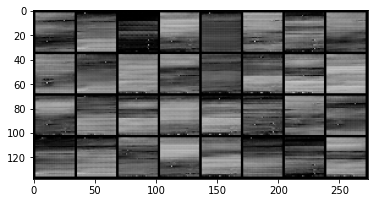

In [36]:
lt, lv = runGAN(chkpt_name='BTCDemoL', dataset='data/FinancialImages/BW/', epochs=1000, use_attn=True, size=32, bw=True)

Epoch 1; Elapsed Time = 0s 
90/97: G=7.120, Dr=0.028, Df=0.032
Saving Checkpoint...
Epoch 2; Elapsed Time = 2s 
90/97: G=8.531, Dr=0.349, Df=0.1604
Epoch 3; Elapsed Time = 5s 
90/97: G=6.025, Dr=0.180, Df=0.139
Epoch 4; Elapsed Time = 7s 
90/97: G=4.847, Dr=0.244, Df=0.207
Epoch 5; Elapsed Time = 10s 
90/97: G=5.088, Dr=0.161, Df=0.145
Epoch 6; Elapsed Time = 12s 
90/97: G=5.269, Dr=0.203, Df=0.173
Epoch 7; Elapsed Time = 15s 
90/97: G=4.870, Dr=0.173, Df=0.171
Epoch 8; Elapsed Time = 17s 
90/97: G=4.687, Dr=0.250, Df=0.232
Epoch 9; Elapsed Time = 20s 
90/97: G=4.680, Dr=0.216, Df=0.217
Epoch 10; Elapsed Time = 22s 
90/97: G=4.847, Dr=0.170, Df=0.159
Epoch 11; Elapsed Time = 25s 
90/97: G=4.899, Dr=0.168, Df=0.159
Saving Checkpoint...
Epoch 12; Elapsed Time = 27s 
90/97: G=4.975, Dr=0.185, Df=0.172
Epoch 13; Elapsed Time = 30s 
90/97: G=5.221, Dr=0.117, Df=0.101
Epoch 14; Elapsed Time = 32s 
90/97: G=5.592, Dr=0.115, Df=0.104
Epoch 15; Elapsed Time = 35s 
90/97: G=5.555, Dr=0.164, Df=0

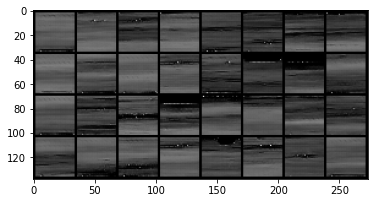

In [27]:
lt, lv = runGAN(chkpt_name='BTCYourRun', dataset='data/FinancialImages/BW/', epochs=100, use_attn=True, size=32, bw=True)

<AxesSubplot:xlabel='index', ylabel='value'>

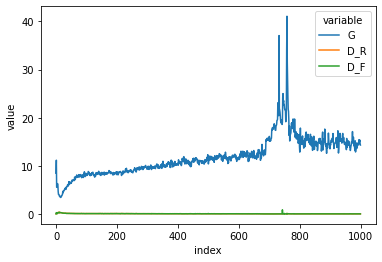

In [37]:
lt_df = pd.melt(pd.DataFrame(lt).rename({0:'G',1:'D_R', 2:'D_F'}, axis=1), ignore_index=False).reset_index()
sns.lineplot(data=lt_df, x='index', y='value', hue='variable')

### Similar training pattern to the earlier GAN - but samples still improve with longer training!

### Below is an example of a latent vector used to generate one of the images!

In [53]:
lv[0]

tensor([-1.5540, -0.0504,  1.7159,  1.4659,  2.3626,  0.4135, -0.1917,  0.6918,
         0.4460,  1.7825,  0.3080, -0.3758, -1.4641,  0.0815,  0.3542, -0.6379])

In [38]:
# Labels all the generated images according to the same paradigm used to label the real ones
def labelsForGenerated(fileList, folder, threshold=90):
    labels = [1]*len(fileList)
    for i, fileName in enumerate(fileList):
        im = transforms.ToTensor()(Image.open(folder + fileName))
        if im[0,0,0] > im[0,31,31]:
            labels[i] = 0
    return labels

# Interpolate between two arrays
def interpolateArrays(X1, X2, n_steps=10):
    return np.linspace(X1, X2, n_steps)

### Here we will explore an important concept: interpolation though the latent space. Basically used to create images that are 'in between' two different samples.

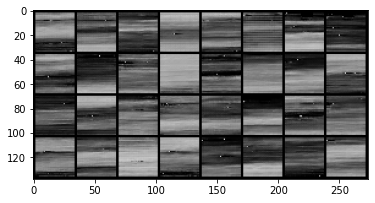

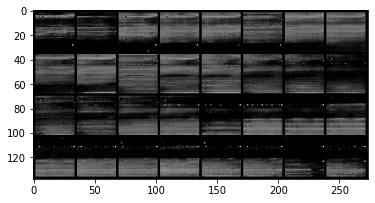

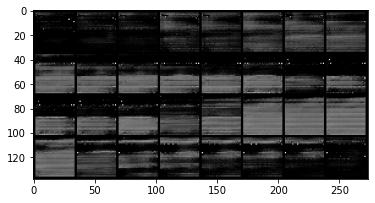

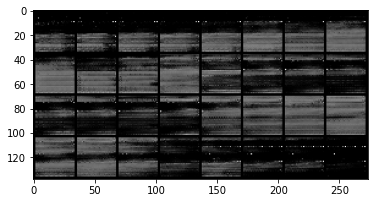

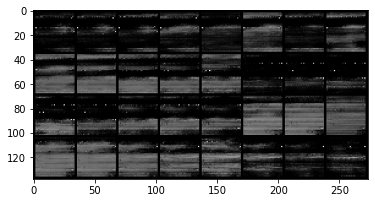

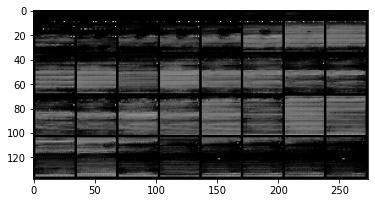

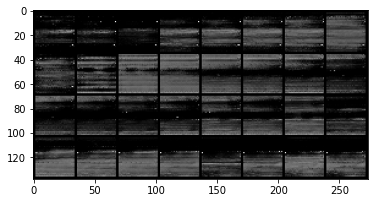

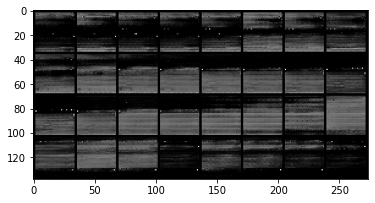

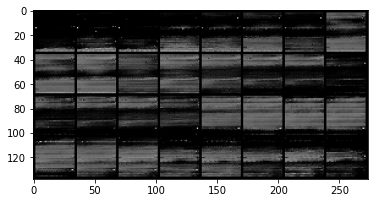

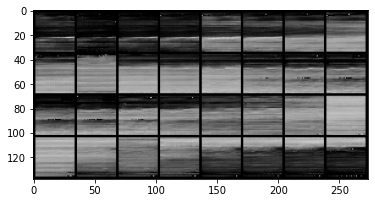

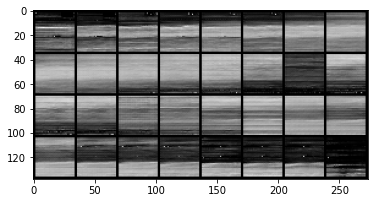

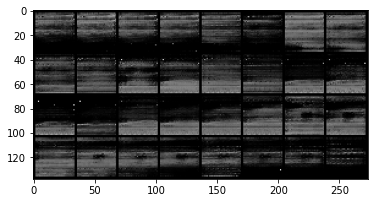

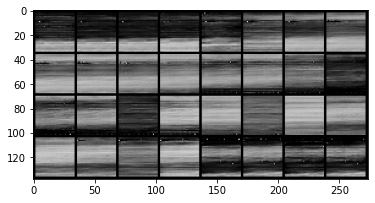

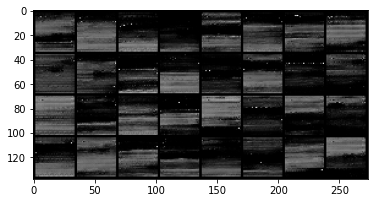

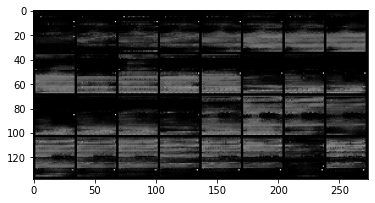

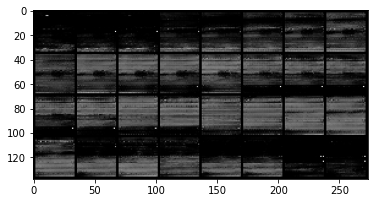

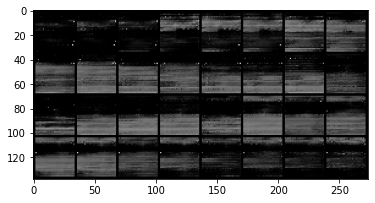

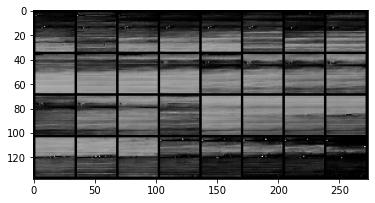

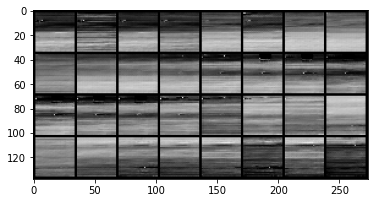

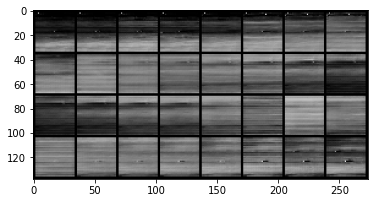

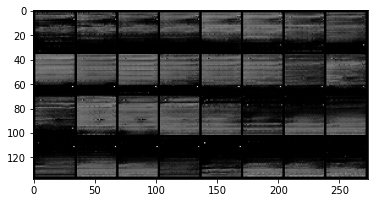

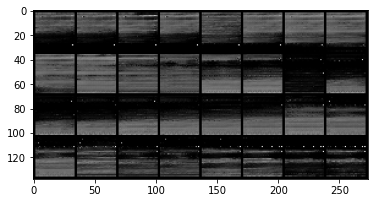

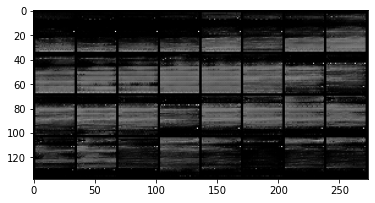

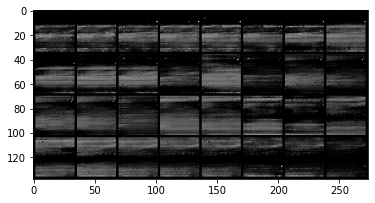

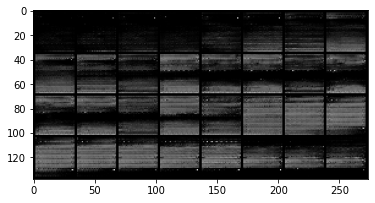

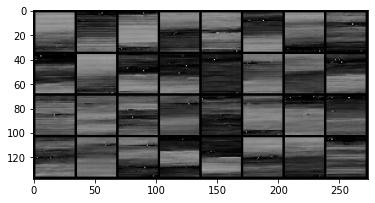

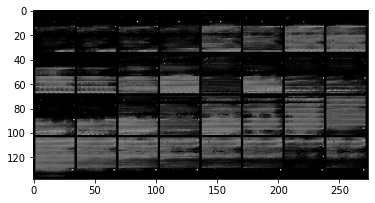

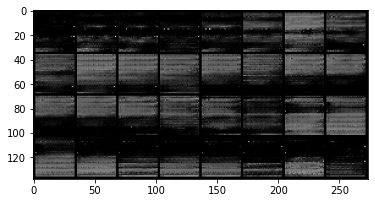

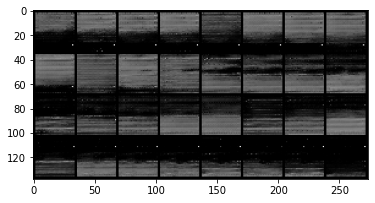

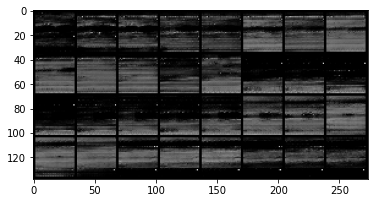

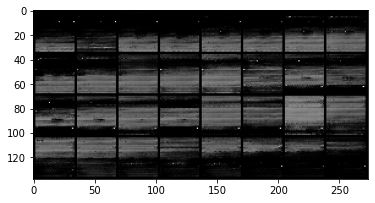

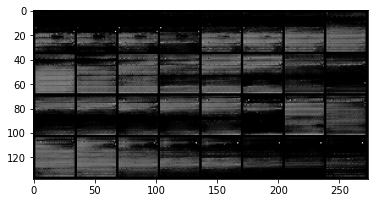

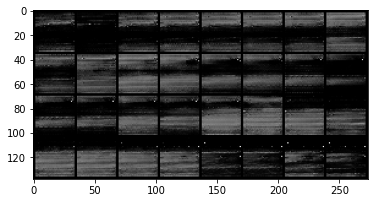

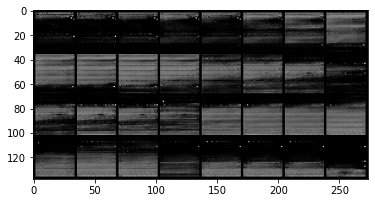

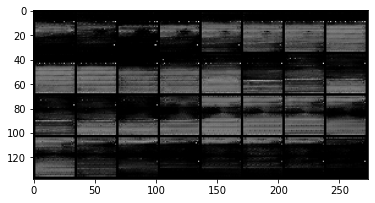

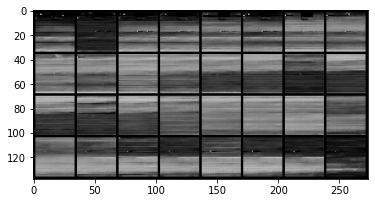

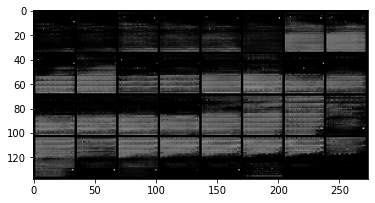

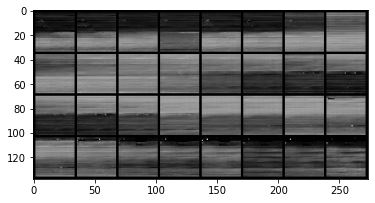

In [45]:
for j in range(3):
    # Generate some samples from a random latent vector
    lt, lv = runGAN(chkpt_name='BTCDemo', dataset='data/FinancialImages/BW', size=32, bw=True, gen_or_train='gen', use_attn=True, folder_mod='Demo/Random/')
    
    # Label the generated images
    dataDir = 'data/GeneratedImages/Demo/Random/'
    listGen = os.listdir(dataDir)
    labels = labelsForGenerated(listGen, dataDir)
    pd_labels = pd.DataFrame(labels)
    
    # Grab only the samples that are labeled 0 (Negative)
    genNegLabels = pd_labels[pd_labels[0]==0].index.values
    run_label = 'run2'
    
    # Interpolate between these selected images
    for i in range(len(genNegLabels)-2):
        # Interpolate in 16 steps between image i and i+1
        interp = interpolateArrays(lv[genNegLabels[i]], lv[genNegLabels[i+1]], n_steps=16)
        # Interpolate in 16 steps between image i+1 and i+2
        interp2 = interpolateArrays(lv[genNegLabels[i+1]], lv[genNegLabels[i+2]], n_steps=16)
        # Join the two sets of latent vectors into one that is the correct size (32, the batch size)
        interp = torch.cat((torch.tensor(interp), torch.tensor(interp2)))
        # Generate samples relative to this latent vector
        lt1, lv1 =runGAN(chkpt_name='BTCDemo', dataset='data/FinancialImages/', size=32, bw=True, gen_or_train='gen', use_attn=True, latent_vec=interp, folder_mod='Demo/Interp/', gen_name_mod= run_label + '_' + str(i)+ str(j))
   

In [46]:
# Put generated data into a dataloader
dataDir = 'data/GeneratedImages/Demo/Interp/'
listGen = os.listdir(dataDir)
setGen_Train = turnToTensors(listGen, dataDir)

targetsGen_Train = torch.FloatTensor(labelsForGenerated(listGen, dataDir))

targetsGen_Train = targetsGen_Train[:, None]
dataGen_Train = torch.utils.data.TensorDataset(setGen_Train, targetsGen_Train)

batchSize = 8

trainLoaderGen = torch.utils.data.DataLoader(dataGen_Train, batch_size = batchSize, shuffle = True)

<AxesSubplot:ylabel='Count'>

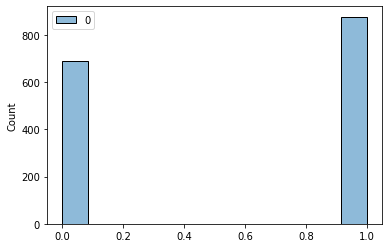

In [47]:
# Class distribution of generated data, not skewed negative even though we interpolated
# between negative samples? 
sns.histplot(data=pd.DataFrame(np.array(targetsGen_Train)))

### Slight amount of mode collapse - an important concept in GAN training! When a model picks a certain subset of the data and becomes better at training that subset that anything else!
![alt text](data/PresentationImages/mode_collapse.jpeg "stonks")

In [48]:
classifierCNN = CNN()

print("Training the model on generated data:")
print('           -------------------------------------')
print('           -------------------------------------')
fit(classifierCNN, trainLoaderGen, 20)
print('           -------------------------------------')
print('')
print('')


print("Evaluation of model on balanced data:")
print('           -------------------------------------')
evalModel(classifierCNN, testLoaderBal, False)
print('           -------------------------------------')
print('')
print('')

print("Evaluation of model on unbalanced data:")
print('           -------------------------------------')
evalModel(classifierCNN, testLoaderNeg, False)
print('           -------------------------------------')


Training the model on generated data:
           -------------------------------------
           -------------------------------------
Epoch : 0 [0/1568 (0%)]	Loss: 0.691297	 Accuracy:62.500%
Epoch : 1 [0/1568 (0%)]	Loss: 0.773271	 Accuracy:62.500%
Epoch : 2 [0/1568 (0%)]	Loss: 0.796155	 Accuracy:75.000%
Epoch : 3 [0/1568 (0%)]	Loss: 0.641685	 Accuracy:75.000%
Epoch : 4 [0/1568 (0%)]	Loss: 0.497850	 Accuracy:87.500%
Epoch : 5 [0/1568 (0%)]	Loss: 0.784962	 Accuracy:50.000%
Epoch : 6 [0/1568 (0%)]	Loss: 0.632734	 Accuracy:62.500%
Epoch : 7 [0/1568 (0%)]	Loss: 0.663006	 Accuracy:75.000%
Epoch : 8 [0/1568 (0%)]	Loss: 0.721981	 Accuracy:75.000%
Epoch : 9 [0/1568 (0%)]	Loss: 0.507526	 Accuracy:75.000%
Epoch : 10 [0/1568 (0%)]	Loss: 0.499076	 Accuracy:62.500%
Epoch : 11 [0/1568 (0%)]	Loss: 0.753007	 Accuracy:75.000%
Epoch : 12 [0/1568 (0%)]	Loss: 0.306031	 Accuracy:87.500%
Epoch : 13 [0/1568 (0%)]	Loss: 0.513851	 Accuracy:87.500%
Epoch : 14 [0/1568 (0%)]	Loss: 0.356904	 Accuracy:100.000%
Epo

In [32]:
# Create augmented dataset of fake and real data
setGenNeg = setGen_Train[targetsGen_Train==0]
setGenNeg = setGenNeg[:, None, :, :]
targetsGenNeg = targetsGen_Train[targetsGen_Train==0]
targetsGenNeg = targetsGenNeg[:, None]

setAug_Train = torch.cat((setPos_Train, setGenNeg))
targetsAug_Train = torch.cat((targetsPos_Train, targetsGenNeg))

dataAug_Train = torch.utils.data.TensorDataset(setAug_Train, targetsAug_Train)
trainLoaderAug = torch.utils.data.DataLoader(dataAug_Train, batch_size = batchSize, shuffle = True)

<AxesSubplot:ylabel='Count'>

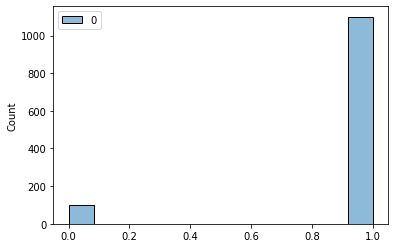

In [338]:
# Reminder: Real sample here is heavily class imbalanced in favor of the positive class
sns.histplot(data=pd.DataFrame(np.array(targetsPos_Train)))

<AxesSubplot:ylabel='Count'>

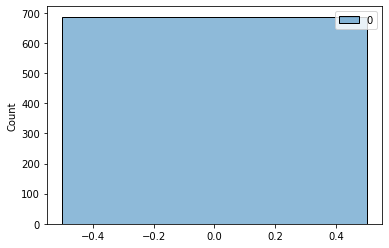

In [34]:
# Fake samples here are only negative classes
sns.histplot(data=pd.DataFrame(np.array(targetsGenNeg)))

<AxesSubplot:ylabel='Count'>

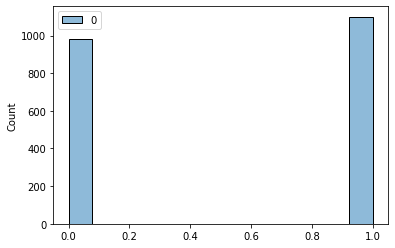

In [360]:
# Augmented dataset is roughly balanced
sns.histplot(data=pd.DataFrame(np.array(targetsAug_Train)))

In [364]:
classifierCNN = CNN()

print("Training the model on augmented data:")
print('           -------------------------------------')
print('           -------------------------------------')
fit(classifierCNN, trainLoaderAug, 20)
print('           -------------------------------------')
print('')
print('')


print("Evaluation of model on balanced data:")
print('           -------------------------------------')
evalModel(classifierCNN, testLoaderBal, False)
print('           -------------------------------------')
print('')
print('')

print("Evaluation of model on unbalanced data:")
print('           -------------------------------------')
evalModel(classifierCNN, testLoaderNeg, False)
print('           -------------------------------------')


Training the model on augmented data:
           -------------------------------------
           -------------------------------------
Epoch : 0 [0/2083 (0%)]	Loss: 0.690757	 Accuracy:75.000%
Epoch : 1 [0/2083 (0%)]	Loss: 0.409075	 Accuracy:87.500%
Epoch : 2 [0/2083 (0%)]	Loss: 0.608113	 Accuracy:100.000%
Epoch : 3 [0/2083 (0%)]	Loss: 0.523096	 Accuracy:87.500%
Epoch : 4 [0/2083 (0%)]	Loss: 0.438327	 Accuracy:87.500%
Epoch : 5 [0/2083 (0%)]	Loss: 0.441481	 Accuracy:100.000%
Epoch : 6 [0/2083 (0%)]	Loss: 0.270143	 Accuracy:100.000%
Epoch : 7 [0/2083 (0%)]	Loss: 0.350658	 Accuracy:87.500%
Epoch : 8 [0/2083 (0%)]	Loss: 0.267496	 Accuracy:100.000%
Epoch : 9 [0/2083 (0%)]	Loss: 0.132430	 Accuracy:100.000%
Epoch : 10 [0/2083 (0%)]	Loss: 0.524219	 Accuracy:100.000%
Epoch : 11 [0/2083 (0%)]	Loss: 0.262351	 Accuracy:100.000%
Epoch : 12 [0/2083 (0%)]	Loss: 0.433373	 Accuracy:100.000%
Epoch : 13 [0/2083 (0%)]	Loss: 0.190469	 Accuracy:87.500%
Epoch : 14 [0/2083 (0%)]	Loss: 0.361293	 Accuracy:75.0

## Here we are able to improve the model performance on both the balanced and unbalanced real data! Cool!

## This approach can be applied across many domains, and may even help you with your dataset problems!

# Thanks for listening! 

![alt text](data/PresentationImages/GANMeme.jpg "stonks")